In [1]:
import os
os.chdir(os.getcwd()[:-6])

In [2]:
from float.data import DataLoader
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.prediction.evaluation import PredictionEvaluator
from float.pipeline import PrequentialPipeline
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.neural_networks.perceptron import PerceptronMask
from skmultiflow.drift_detection.adwin import ADWIN
from sklearn.metrics import zero_one_loss
from float.visualization import plot, spider_chart, concept_drifts_scatter
from float.prediction.evaluation.measures import noise_variability, mean_drift_performance_deterioration
from float.change_detection import ERICS
from float.change_detection.skmultiflow import SkmultiflowChangeDetector
from float.change_detection.evaluation import ChangeDetectionEvaluator
from float.change_detection.evaluation.measures import mean_time_ratio
import matplotlib.pyplot as plt

In [3]:
data_loader = DataLoader(None, f'float/data/datasets/spambase.csv', target_col=0)

known_drifts = [round(data_loader.stream.n_samples * 0.2), round(data_loader.stream.n_samples * 0.4),
                round(data_loader.stream.n_samples * 0.6), round(data_loader.stream.n_samples * 0.8)]

predictor = SkmultiflowClassifier(HoeffdingTreeClassifier(), data_loader.stream.target_values, reset_after_drift=True)
pred_evaluator = PredictionEvaluator([zero_one_loss], decay_rate=0.1, window_size=10)

change_detectors = [SkmultiflowChangeDetector(ADWIN(delta=0.6), reset_after_drift=False),
                           ERICS(data_loader.stream.n_features)]
cd_evaluators = [ChangeDetectionEvaluator(measure_funcs=[mean_time_ratio],
                                        known_drifts=known_drifts,
                                        batch_size=10,
                                        n_total=data_loader.stream.n_samples,
                                        n_delay=list(range(100, 1000)),
                                        n_init_tolerance=100)
               for i in range(2)]
for i in range(2):
    prequential_pipeline = prequential_pipeline = PrequentialPipeline(data_loader=data_loader,
                                               change_detector=change_detectors[i],
                                               change_detection_evaluator=cd_evaluators[i],
                                               predictor=predictor,
                                               prediction_evaluator=pred_evaluator,
                                               batch_size=10,
                                               n_max=data_loader.stream.n_samples - 10,
                                               known_drifts=known_drifts,)
    prequential_pipeline.run()

Pretrain the predictor with 100 observation(s).
[====================] 100%, No. of detected drifts: 0, Last detected drift at t=0.
################################## SUMMARY ##################################
Evaluation has finished after 14.319146633148193s
Data Set float/data/datasets/spambase.csv
The pipeline has processed 4591 instances in total, using batches of size 10.
----------------------
Concept Drift Detection:
| Model   |   Avg. Comp. Time | Detected Global Drifts   |   Avg. mean_time_ratio |
|---------|-------------------|--------------------------|------------------------|
| ADWIN   |        0.00111401 | []                       |                      0 |
----------------------
Prediction:
| Model                   |   Avg. Test Comp. Time |   Avg. Train Comp. Time |   Avg. zero_one_loss |
|-------------------------|------------------------|-------------------------|----------------------|
| HoeffdingTreeClassifier |             0.00941813 |               0.0168259 |   

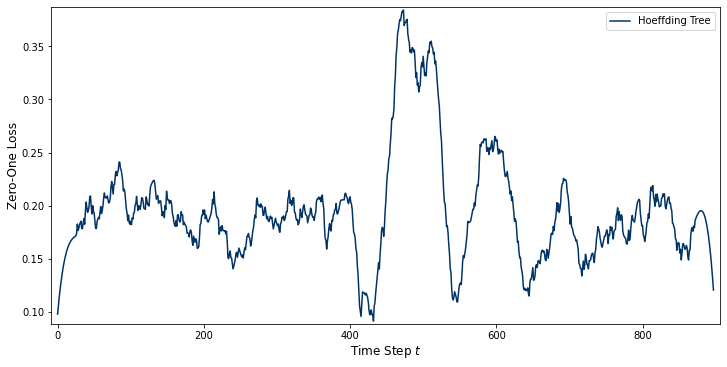

In [4]:
plot(measures=[pred_evaluator.result['zero_one_loss']['measures']],
     labels=['Hoeffding Tree'],
     measure_name='Zero-One Loss',
     measure_type='prediction',
     smooth_curve=[True])
plt.show()

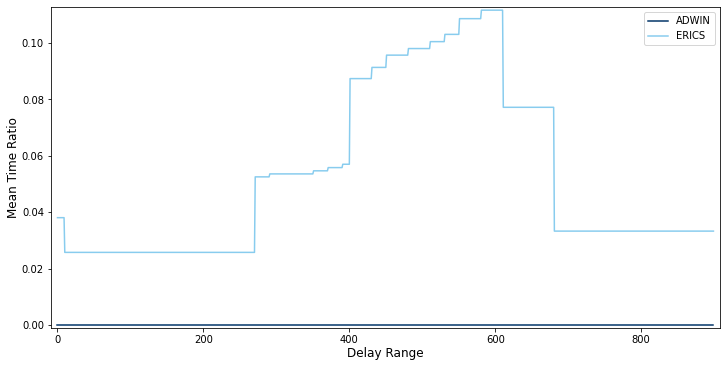

In [5]:
plot(measures=[cd_evaluators[0].result['mean_time_ratio']['measures'], cd_evaluators[1].result['mean_time_ratio']['measures']],
     labels=['ADWIN', 'ERICS'],
     measure_name='Mean Time Ratio',
     measure_type='change_detection')
plt.show()

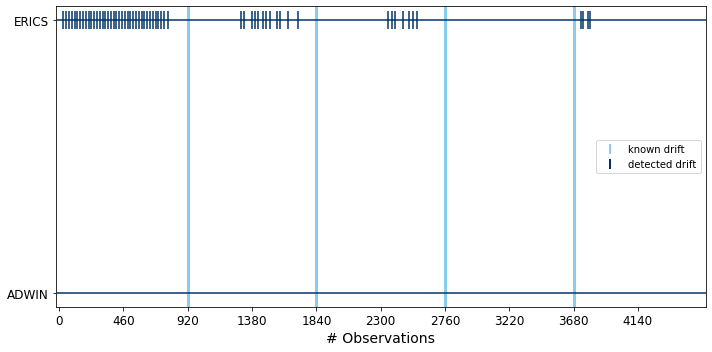

In [6]:
concept_drifts_scatter(measures=[change_detectors[0].drifts, change_detectors[1].drifts],
                       labels=['ADWIN', 'ERICS'],
                       measure_type='change_detection',
                       data_stream=data_loader.stream,
                       known_drifts=known_drifts,
                       batch_size=10)
plt.show()